# Notebook with experements for participant in text classification

## import bibliotek and fetch data

In [12]:
import pandas as pd
from pathlib import Path
from transformers import BertTokenizer, BertModel, BertConfig, DistilBertModel, DistilBertConfig
import torch
from torch.utils.data import DataLoader
from torch import nn
from torch.nn import functional as F
import numpy as np
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from nltk.tokenize import word_tokenize
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from IPython.display import clear_output
import random
from subprocess import Popen, PIPE
import copy
import warnings
from tqdm import tqdm
from math import ceil
from gensim.models import Word2Vec


def set_random_seed(seed=42):
    torch.manual_seed(seed)
    np.random.seed(seed)
    random.seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed_all(seed)

def run_command(cmd: list, cwd='.', wait=True):
    p = Popen(cmd, cwd=cwd, stdout=PIPE, stderr=PIPE)
    if wait:
        p.wait()
        err = p.stderr.read().decode('utf-8')
        if err:
            print('Got error while executing "', *cmd, f'": {err}')

    return p


def save_df_zip(df: pd.DataFrame, out = 'res'):
    df.to_csv(out + '.csv', index=False)
    run_command(['zip', '-r', out + '.zip', out + '.csv'], wait=True)


set_random_seed()

data_dir = Path('public_data')

In [13]:
def get_train_df():
    df = pd.read_csv(data_dir / 'train_data.csv')
    df['category'] = 0
    res_df = pd.read_csv(data_dir / 'train_solution.csv')
    df.loc[df['id'].isin(res_df[res_df['category'] == 1]['id']), 'category'] = 1
    df.loc[df['id'].isin(res_df[res_df['category'] == 2]['id']), 'category'] = 2
    return df

df = get_train_df()
test_df = pd.read_csv(data_dir / 'test_data.csv')

# Collected from telegram open chats
additional_df = pd.read_csv('additional_data.csv')
df.head()

,id,message,category
0,271828,Over $616 million in Bitcoin was electrocated ...,1
1,271829,Quiz: Thursday or friday?,0
2,271830,The Australian Revenue Authority will start co...,1
3,271831,Let's continue😉. I present to you my new review,2
4,271832,Here comes your future palette.,2


## Experements

### Catboost over one hot encoded message (0.81 on public/0.91 on private)

In [14]:
tokens_dict = {}
def tokenize(msg):
    return word_tokenize(msg.lower(), preserve_line=True)

def score(model, x, y):
    preds = model.predict(x)
    return accuracy_score(preds, y)

for _, row in df.iterrows():
    msg = tokenize(row['message'])
    for word in msg:
        if word not in tokens_dict:
            tokens_dict[word] = 0
        tokens_dict[word] += 1

In [15]:
all_tokens = list(tokens_dict.items())
all_tokens.sort(key=lambda x: x[1], reverse=True)
len(all_tokens)

21398

In [16]:
popular_tokens = all_tokens[:2500]
tokens = list(x[0] for x in popular_tokens)
tokens2ids = dict((x, i) for i, x in enumerate(tokens))


In [17]:
def get_encoding_from_msg(msg):
    tokenized_msg = tokenize(msg)
    res = np.zeros(len(tokens2ids), dtype=int)
    for token in tokenized_msg:
        if token in tokens2ids:
            res[tokens2ids[token]] = 1

    return res


def make_dataset(df, train=True):
    res = []
    y = []
    ids = []
    if 'category' not in df.columns:
        train=False

    for _, row in df.iterrows():
        try:
            ids.append(row['id'])
            res.append(get_encoding_from_msg(row['message']))
        except:
            print(row)
        if train:
            y.append(row['category'])

    return np.array(ids), np.array(res), np.array(y) if train else None

_, x, y = make_dataset(df)
_, x_add, y_add = make_dataset(additional_df)
ids_test, x_test, _ = make_dataset(test_df)

In [18]:
big_x = np.append(x, x_add, axis=0)
big_y = np.append(y, y_add)
big_y.shape, big_x.shape

((10363,), (10363, 2500))

In [19]:
x_train, x_val, y_train, y_val = train_test_split(big_x, big_y, test_size=0.1, stratify=big_y, random_state=997)

In [20]:
set_random_seed(997)
cb = CatBoostClassifier(depth=8)
cb.fit(x_train, y_train)
clear_output()
score(cb, x_val, y_val)

0.7675988428158148

In [21]:
def get_confident_preds(model, x, threshold=0.91):
    preds = model.predict_proba(x)
    d = np.array(list(preds[i, t] for i, t in enumerate(np.argmax(preds, axis=-1))))
    res = -np.ones(d.shape[0], dtype=int)
    where = np.where(d > threshold)[0]
    res[where] = model.predict(x).reshape(-1)[where]
    return res

bp = get_confident_preds(cb, x_val)

In [23]:
v = 4
a = cb.feature_importances_
important_tokens = np.argpartition(a, -v)[-v:]
np.array(tokens)[important_tokens], cb.feature_importances_[important_tokens]

(array(['project', 'i', ':', '.'], dtype='<U16'),
 array([3.44154297, 3.80198443, 4.08883288, 6.45054394]))

In [33]:
set_random_seed(997)
cb = CatBoostClassifier(depth=8)
cb.fit(x, y)
clear_output()
res_cb = cb.predict(x_test)

In [35]:
res_df = pd.DataFrame({'id': ids_test, 'category': res_cb.reshape(-1)})
save_df_zip(res_df)

## Word2vec training

In [27]:
big_df = pd.concat((df, additional_df))
all_messages = list(df['message'].values) + list(test_df['message'].values)
msg_words = [tokenize(msg) for msg in all_messges]


In [36]:
size = 256
model_w2v = Word2Vec(msg_words, window=4, size=size, min_count=2, workers=8)

/Users/panesher/miniconda3/lib/python3.9/site-packages/gensim/models/base_any2vec.py:322: UserWarning: C extension not loaded, training will be slow. Install a C compiler and reinstall gensim for fast training.
  warnings.warn(


In [37]:
model_w2v.train(msg_words, total_examples=model_w2v.corpus_count, epochs=15)

(5697730, 8105880)

In [38]:
def w2v_transform(sent):
    ans = np.zeros(size)
    num_words = 0
    for word in sent:
        if word in model_w2v.wv:
            ans += model_w2v.wv[word]
            num_words += 1

    return ans


def w2v_transform_msg(msg):
    return w2v_transform(tokenize(msg))


x_w2v = np.array([*df['message'].apply(w2v_transform_msg)])
x_test_w2v = np.array([*test_df['message'].apply(w2v_transform_msg)])

In [39]:
add_x_w2v, add_y = np.array([*additional_df['message'].apply(w2v_transform_msg)]), np.array(additional_df['category'])

In [40]:
x_train_w2v, x_val_w2v, y_train_w2v, y_val_w2v = train_test_split(x_w2v, y, test_size=0.1, stratify=y, random_state=997)

## Catboost 2 model: 1 from 1 p. and one over w2v encodings (0.82 on public score)

In [41]:
set_random_seed(997)
cb_w2v = CatBoostClassifier(depth=8)
cb_w2v.fit(x_train_w2v, y_train_w2v)
clear_output()
score(cb_w2v, x_val_w2v, y_val_w2v)

0.8571428571428571

In [42]:
set_random_seed(997)
cb_w2v = CatBoostClassifier(depth=8)
cb_w2v.fit(x_w2v, y)
clear_output()

In [43]:
res_cb = cb_w2v.predict(x_test_w2v)
res_df = pd.DataFrame({'id': ids_test, 'category': res_cb.reshape(-1)})
save_df_zip(res_df)

In [44]:
_, x, y = make_dataset(df)
ids_test, x_test, _ = make_dataset(test_df)
x_train, x_val, y_train, y_val = train_test_split(x, y, test_size=0.1, stratify=y, random_state=997)

In [45]:
set_random_seed(997)
cb = CatBoostClassifier(depth=8)
cb.fit(x, y)
clear_output()

In [46]:
def make_best_preds(cb, cb_w2v, x, x_w2v):
    preds = [cb.predict_proba(x), cb_w2v.predict_proba(x_w2v)]
    preds = np.concatenate(preds, axis=1)
    return np.argmax(preds, axis=1) % 3

p = make_best_preds(cb, cb_w2v, x_test, x_test_w2v)

In [47]:
res_df = pd.DataFrame({'id': ids_test, 'category': p.reshape(-1)})
save_df_zip(res_df)

## Fully connected model over word2vec encodings (0.84/0.93)

In [56]:
class Model(nn.Module):
    def __init__(self, hidden_size=128, dropout=0.1):
        super().__init__()
        self.seq = nn.Sequential(
            # here was from 3 to 6 layers
            nn.Linear(size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, hidden_size),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_size, 3),
        )
    
    def forward(self, x):
        return self.seq(x)


class DS(torch.utils.data.Dataset):
    def __init__(self, x, y = None, ids=None) -> None:
        super().__init__()
        self.x = x
        self.y = y
        self.ids = ids
    
    def __len__(self):
        return len(self.x)
    
    def __getitem__(self, idx):
        if self.y is None:
            if self.ids is None:
                return self.x[idx]

            return self.ids[idx], self.x[idx]

        return self.x[idx], self.y[idx]

In [57]:
big_x = np.concatenate((add_x_w2v, x_train_w2v), axis=0)
big_y = np.concatenate((add_y, y_train_w2v), axis=0)

In [58]:
batch_size = 16

# train_ds = DS(big_x, big_y)
train_ds = DS(x_train_w2v, y_train_w2v)
val_ds = DS(x_val_w2v, y_val_w2v)
test_ds = DS(x_test_w2v, ids=ids_test)

train_dl = torch.utils.data.DataLoader(train_ds, batch_size=batch_size)
val_dl = torch.utils.data.DataLoader(val_ds, batch_size=batch_size)
test_dl = torch.utils.data.DataLoader(test_ds, batch_size=batch_size)

In [59]:
warnings.filterwarnings('ignore')
device = 'cuda' if torch.cuda.is_available() else 'cpu'

model_path = 'model_last.pt'
model_best_path = 'model_best.pt'


def train_epoch(model, optimizer):
    loss_log, acc_log = [], []
    model.train()
    for x_batch, y_batch in tqdm(train_dl, total=ceil(len(train_ds) / batch_size)):
        data = x_batch
        target = y_batch

        optimizer.zero_grad()
        output = model(data)

        pred = torch.argmax(output, dim=1)
        acc = torch.eq(pred, y_batch).float().mean().cpu()
        acc_log.append(acc)

        loss = F.cross_entropy(output, target).cpu()
        loss.backward()
        loss_log.append(loss.item())
        optimizer.step()

    return loss_log, acc_log


def test(model):
    loss_log, acc_log = [], []
    model.eval()
    for x_batch, y_batch in tqdm(val_dl, total=ceil(len(val_ds) / batch_size)):
        data = x_batch
        target = y_batch

        output = model(data)
        loss = F.cross_entropy(output, target).cpu()

        pred = torch.argmax(output, dim=1)
        acc = torch.eq(pred, y_batch).float().mean().cpu()
        acc_log.append(acc)

        loss = loss.item()
        loss_log.append(loss)

    return loss_log, acc_log


def plot_history(train_history, val_history, title='loss'):
    plt.figure()
    plt.title('{}'.format(title))
    plt.plot(train_history, label='train', zorder=1)

    points = np.array(val_history)

    plt.scatter(points[:, 0], points[:, 1], marker='+',
                s=180, c='orange', label='val', zorder=2)
    plt.xlabel('train steps')

    plt.legend(loc='best')
    plt.grid()

    plt.show()


def train(model, opt, n_epochs):
    train_log, train_acc_log = [], []
    val_log, val_acc_log = [], []
    best_acc = 0.

    for epoch in range(n_epochs):
        print("Epoch {0} of {1}".format(epoch, n_epochs))
        train_loss, train_acc = train_epoch(model, opt)
        torch.save(model, model_path)

        val_loss, val_acc = test(model)
        if best_acc < np.mean(val_acc):
            best_acc = np.mean(val_acc)
            torch.save(model, model_best_path)

        train_log.extend(train_loss)
        train_acc_log.extend(train_acc)

        steps = len(train_ds) / batch_size
        val_log.append((steps * (epoch + 1), np.mean(val_loss)))
        val_acc_log.append((steps * (epoch + 1), np.mean(val_acc)))

        clear_output()
        plot_history(train_log, val_log)
        plot_history(train_acc_log, val_acc_log, title='accuracy')

        print("Epoch: {2}, val loss: {0}, val accuracy: {1}".format(
            np.mean(val_loss), np.mean(val_acc), epoch))


In [60]:
# тут точно не помню какие параметры на лучшей посылки, хотя результаты схожи ~0.84
model = Model(256, 0.2).double()
opt = torch.optim.Adam(model.parameters(), lr=3e-4)

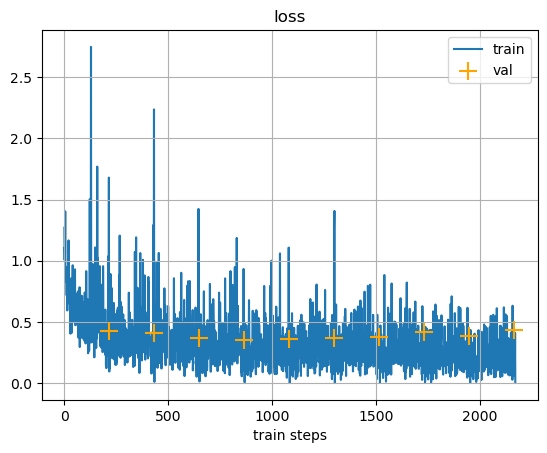

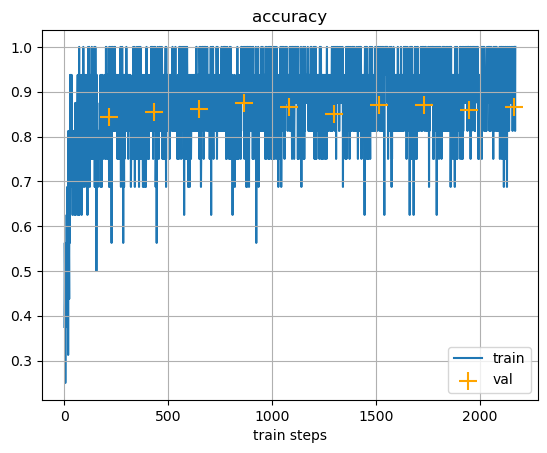

Epoch: 9, val loss: 0.4318479710135479, val accuracy: 0.8650000095367432


In [61]:
train(model, opt, 10)

In [62]:
def predict(model):
    result = {
        'id': [],
        'category': []
    }
    model.eval()
    for ids, x_batch in tqdm(test_dl, total=ceil(len(test_ds) / batch_size)):
        with torch.no_grad():
            pred = torch.argmax(model(x_batch), dim=1)
            result['id'] += ids.tolist()
            result['category'] += pred.tolist()

    return pd.DataFrame(result)


model = torch.load(model_best_path).to(device)
res = predict(model)

100%|██████████| 371/371 [00:00<00:00, 5409.90it/s]


In [63]:
save_df_zip(res)